# Pulling data from the NHS BSA Open Data Portal (ODP) using Python

In [1]:
# Import any packages
import warnings
import requests
import pandas as pd
import matplotlib

# Disable SSL cert warnings
warnings.filterwarnings('ignore')

# Make the plots appear inline
%matplotlib inline

The ODP https://opendata.nhsbsa.net/ has two programatic methods to access data from it...

* `datastore_search` e.g. https://opendata.nhsbsa.net/api/3/action/datastore_search?resource_id=EPD_201401&limit=5
* `datastore_search_sql` e.g. https://opendata.nhsbsa.net/api/3/action/datastore_search_sql?resource_id=EPD201401&sql=SELECT%20*%20FROM%20EPD_201401%20LIMIT%205

The following code demonstrates the process using the SQL style query. It is a more flexible way to access any data and easy if you already know some SQL (if not don't worry - the code is there for you to follow).

In [2]:
# Define the url for the API call
base_endpoint = "https://opendata.nhsbsa.net/api/3/action"
action_method = "/datastore_search_sql?" # SQL

In [3]:
# Define the parameters for the SQL query
resource_name = "EPD_202001"
pco_code = "13T00" # Newcastle Gateshead CCG
bnf_chemical_substance = "0407010H0" # Paracetamol

In [4]:
# Construct the SQL query
query = f"""
    SELECT 
        *
    FROM 
        {resource_name} 
    WHERE 
        1=1
        AND pco_code = '{pco_code}' 
        AND bnf_chemical_substance = '{bnf_chemical_substance}' 
"""

In [5]:
# Send API call and grab the response as a json
response = requests.get(
    url=(
        base_endpoint 
        + action_method 
        + "resource_id=" + resource_name
        + "&"
        + "sql=" + requests.utils.quote(query) # Encode url
    ),
    verify=False
).json()

In [6]:
# Convert the records in the response to a pandas dataframe
result_df = pd.DataFrame(response['result']['result']['records'])

In [7]:
# View the first 5 rows of data
result_df.head()

,BNF_CODE,TOTAL_QUANTITY,POSTCODE,YEAR_MONTH,UNIDENTIFIED,PRACTICE_NAME,BNF_CHAPTER_PLUS_CODE,ACTUAL_COST,QUANTITY,REGIONAL_OFFICE_CODE,...,ADQUSAGE,PCO_CODE,REGIONAL_OFFICE_NAME,NIC,CHEMICAL_SUBSTANCE_BNF_DESCR,PRACTICE_CODE,PCO_NAME,AREA_TEAM_NAME,BNF_DESCRIPTION,ADDRESS_1
0,0407010H0AAAMAM,168.0,NE3 1EE,202001,False,ST OSWALDS PALLIATIVE CARE,04: Central Nervous System,3.83164,168.0,Y54,...,28.00000,13T00,NORTH OF ENGLAND,4.00,Paracetamol,Y00505,NEWCASTLE GATESHEAD CCG,"CUMBRIA,NORTHUMB,TYNE & WEAR AREA",Paracetamol 500mg tablets,ST OSWALDS HOSPICE
1,0407010H0AAACAC,400.0,NE12 8EW,202001,False,NDUC NEWCASTLE GATESHEAD OOH,04: Central Nervous System,7.74841,400.0,Y54,...,6.66667,13T00,NORTH OF ENGLAND,8.32,Paracetamol,Y00656,NEWCASTLE GATESHEAD CCG,"CUMBRIA,NORTHUMB,TYNE & WEAR AREA",Paracetamol 250mg/5ml oral suspension,VOCARE HOUSE
2,0407010H0AAAAAA,100.0,NE1 4LP,202001,False,NEWCASTLE GP IN A&E SERVICE,04: Central Nervous System,2.85762,100.0,Y54,...,16.66667,13T00,NORTH OF ENGLAND,3.06,Paracetamol,Y04832,NEWCASTLE GATESHEAD CCG,"CUMBRIA,NORTHUMB,TYNE & WEAR AREA",Paracetamol 500mg capsules,ACCIDENT & EMERGENCY DPT
3,0407010H0AAAMAM,400.0,NE4 6SS,202001,False,MARIE CURIE HOSPICE,04: Central Nervous System,8.87658,200.0,Y54,...,66.66667,13T00,NORTH OF ENGLAND,9.52,Paracetamol,Y05648,NEWCASTLE GATESHEAD CCG,"CUMBRIA,NORTHUMB,TYNE & WEAR AREA",Paracetamol 500mg tablets,MARIE CURIE HOSPICE
4,0407010H0AAACAC,200.0,NE9 6SX,202001,False,WALK-IN CENTRE GP IN-HOURS,04: Central Nervous System,3.89281,100.0,Y54,...,3.33333,13T00,NORTH OF ENGLAND,4.16,Paracetamol,Y04106,NEWCASTLE GATESHEAD CCG,"CUMBRIA,NORTHUMB,TYNE & WEAR AREA",Paracetamol 250mg/5ml oral suspension,WALK-IN CENTRE


Next up we can utilise some of the inbuilt `pandas` plotting functionality (with a `matplotlib` backend) to create some quick and easy visualisations of the `QUANITY` column.

Note that the `;` at the end of each plot hides the metadata:
https://stackoverflow.com/questions/38968404/hide-matplotlib-descriptions-in-jupyter-notebook

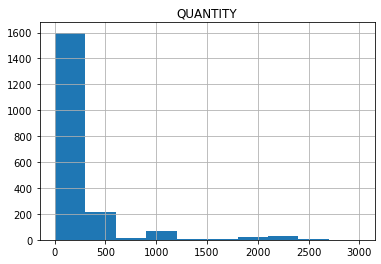

In [8]:
# Lets inspect the QUANTITY column
result_df.hist(column='QUANTITY');

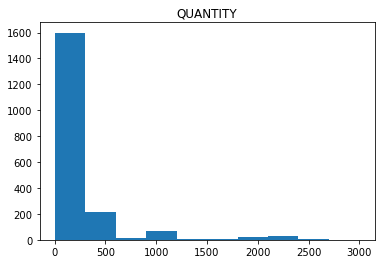

In [9]:
# Remove the background
result_df.hist(column='QUANTITY', grid=False);

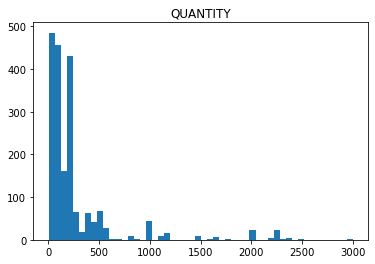

In [10]:
# How about using more bins
result_df.hist(column='QUANTITY', grid=False, bins=50);

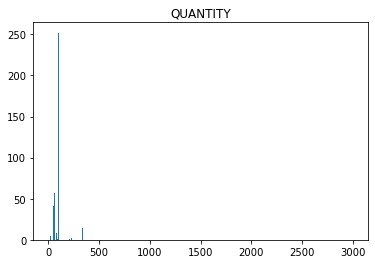

In [11]:
# One bin per value of QUANTITY
max_quantity = int(max(result_df['QUANTITY']))
result_df.hist(
    column='QUANTITY', 
    grid=False, 
    bins=max_quantity
);

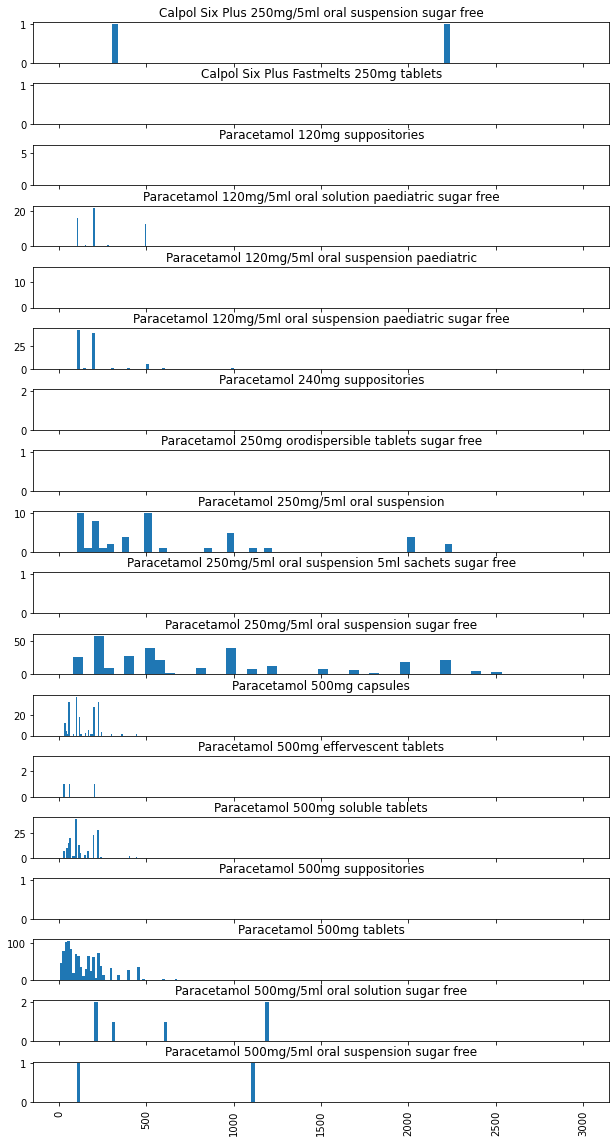

In [12]:
# Lets see if QUANTITY varies by BNF_DESCRIPTION
result_df.hist(
    column='QUANTITY', 
    by='BNF_DESCRIPTION',
    grid=False, 
    bins=50,
    sharex=True, # All the rows share the same x axis
    layout=(18, 1), # 18 rows and one column
    figsize=(10, 20) # Make the graph big enough 
);

We can see that `BNF_DESCRIPTION` contains different forms for the drugs, and that the `QUANTITY` differs (look at `BNF_DESCRIPTION == 'Paracetamol 250mg/5ml oral suspension sugar free'`)

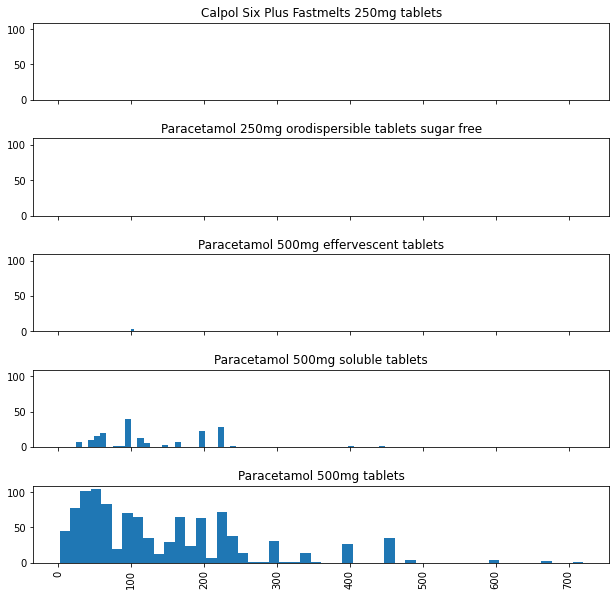

In [13]:
# Subset the data to tablets
tablet_df = result_df[result_df['BNF_DESCRIPTION'].str.contains('tablet')]

# Lets see if QUANTITY varies by BNF_DESCRIPTION
tablet_df.hist(
    column='QUANTITY', 
    by='BNF_DESCRIPTION',
    grid=False, 
    bins=50,
    sharex=True,
    sharey=True,
    layout=(5, 1),
    figsize=(10, 10) # Make the figure big enough for the plot
);

In [14]:
# We can see there are peaks for certain QUANTITY so lets examine the 10 most 
# common QUANITTY
tablet_df['QUANTITY'].value_counts().head(10)

100.0    106
224.0     90
200.0     85
56.0      77
112.0     73
168.0     59
28.0      59
60.0      57
32.0      50
64.0      47
Name: QUANTITY, dtype: int64

TASK

Create another subset called `oral_suspension_df` (containing only 'oral suspension' instead of 'tablet') and then for `QUANTITY`:

1) Produce an overall histogram
2) Produce one histogram per `BNF_DESCRITPION`
3) Get the top 5 most common `QUANTITY`

In [ ]:
# Do your work in here
